In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ilpd-final-project/ilpd.csv


## import library

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

from catboost import CatBoostClassifier
from sklearn.impute import KNNImputer
from imblearn.over_sampling import SMOTENC
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

from sklearn.ensemble import StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

## read data

In [4]:
df = pd.read_csv('/kaggle/input/ilpd-final-project/ilpd.csv')
df.head()

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,1


## data understanding

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Age                         583 non-null    int64  
 1   Gender                      583 non-null    object 
 2   Total_Bilirubin             583 non-null    float64
 3   Direct_Bilirubin            583 non-null    float64
 4   Alkaline_Phosphotase        583 non-null    int64  
 5   Alamine_Aminotransferase    583 non-null    int64  
 6   Aspartate_Aminotransferase  583 non-null    int64  
 7   Total_Protiens              583 non-null    float64
 8   Albumin                     583 non-null    float64
 9   Albumin_and_Globulin_Ratio  579 non-null    float64
 10  Dataset                     583 non-null    int64  
dtypes: float64(5), int64(5), object(1)
memory usage: 50.2+ KB


In [6]:
df.isnull().sum()

Age                           0
Gender                        0
Total_Bilirubin               0
Direct_Bilirubin              0
Alkaline_Phosphotase          0
Alamine_Aminotransferase      0
Aspartate_Aminotransferase    0
Total_Protiens                0
Albumin                       0
Albumin_and_Globulin_Ratio    4
Dataset                       0
dtype: int64

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,583.0,44.746141,16.189833,4.0,33.0,45.00,58.0,90.0
Total_Bilirubin,583.0,3.298799,6.209522,0.4,0.8,1.00,2.6,75.0
Direct_Bilirubin,583.0,1.486106,2.808498,0.1,0.2,0.30,1.3,19.7
Alkaline_Phosphotase,583.0,290.576329,242.937989,63.0,175.5,208.00,298.0,2110.0
Alamine_Aminotransferase,583.0,80.713551,182.620356,10.0,23.0,35.00,60.5,2000.0
Aspartate_Aminotransferase,583.0,109.910806,288.918529,10.0,25.0,42.00,87.0,4929.0
Total_Protiens,583.0,6.483190,1.085451,2.7,5.8,6.60,7.2,9.6
Albumin,583.0,3.141852,0.795519,0.9,2.6,3.10,3.8,5.5
Albumin_and_Globulin_Ratio,579.0,0.947064,0.319592,0.3,0.7,0.93,1.1,2.8
Dataset,583.0,1.286449,0.452490,1.0,1.0,1.00,2.0,2.0


## eda & preprocessing

### encoding

In [8]:
df.dtypes

Age                             int64
Gender                         object
Total_Bilirubin               float64
Direct_Bilirubin              float64
Alkaline_Phosphotase            int64
Alamine_Aminotransferase        int64
Aspartate_Aminotransferase      int64
Total_Protiens                float64
Albumin                       float64
Albumin_and_Globulin_Ratio    float64
Dataset                         int64
dtype: object

In [9]:
le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])

## missing value handling

In [10]:
df.isnull().sum()

Age                           0
Gender                        0
Total_Bilirubin               0
Direct_Bilirubin              0
Alkaline_Phosphotase          0
Alamine_Aminotransferase      0
Aspartate_Aminotransferase    0
Total_Protiens                0
Albumin                       0
Albumin_and_Globulin_Ratio    4
Dataset                       0
dtype: int64

In [11]:
imputer = KNNImputer(n_neighbors=5)
df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
df.isnull().sum()

Age                           0
Gender                        0
Total_Bilirubin               0
Direct_Bilirubin              0
Alkaline_Phosphotase          0
Alamine_Aminotransferase      0
Aspartate_Aminotransferase    0
Total_Protiens                0
Albumin                       0
Albumin_and_Globulin_Ratio    0
Dataset                       0
dtype: int64

## scaling

In [12]:
df.head()

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
0,65.0,0.0,0.7,0.1,187.0,16.0,18.0,6.8,3.3,0.90,1.0
1,62.0,1.0,10.9,5.5,699.0,64.0,100.0,7.5,3.2,0.74,1.0
2,62.0,1.0,7.3,4.1,490.0,60.0,68.0,7.0,3.3,0.89,1.0
3,58.0,1.0,1.0,0.4,182.0,14.0,20.0,6.8,3.4,1.00,1.0
4,72.0,1.0,3.9,2.0,195.0,27.0,59.0,7.3,2.4,0.40,1.0


In [13]:
scaler = MinMaxScaler()
features = df.drop(['Dataset'], axis=1).columns

df[features] = scaler.fit_transform(df[features])

df.head()

,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
0,0.709302,0.0,0.004021,0.000000,0.060576,0.003015,0.001626,0.594203,0.521739,0.240,1.0
1,0.674419,1.0,0.140751,0.275510,0.310699,0.027136,0.018296,0.695652,0.500000,0.176,1.0
2,0.674419,1.0,0.092493,0.204082,0.208598,0.025126,0.011791,0.623188,0.521739,0.236,1.0
3,0.627907,1.0,0.008043,0.015306,0.058134,0.002010,0.002033,0.594203,0.543478,0.280,1.0
4,0.790698,1.0,0.046917,0.096939,0.064485,0.008543,0.009961,0.666667,0.326087,0.040,1.0


## class distribution

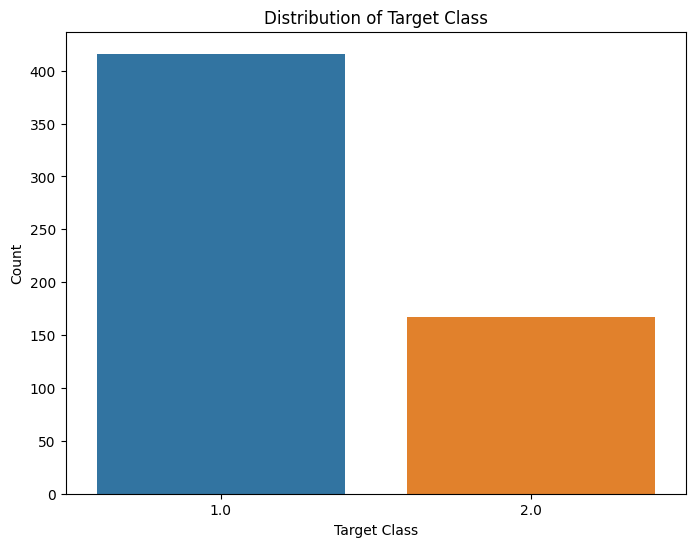

In [14]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Dataset', data=df)
plt.title('Distribution of Target Class')
plt.xlabel('Target Class')
plt.ylabel('Count')
plt.show()

This data set contains 416 liver patient records and 167 non liver patient records.The data set was collected from test samples in North East of Andhra Pradesh, India. 'is_patient' is a class label used to divide into groups(liver patient or not). This data set contains 441 male patient records and 142 female patient records.

In [15]:
df['Dataset'] = df['Dataset'].map({1: 1, 2: 0})

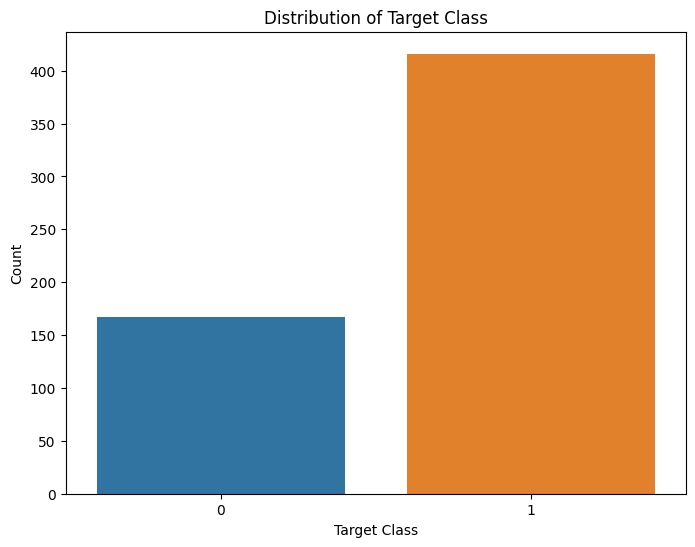

In [16]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Dataset', data=df)
plt.title('Distribution of Target Class')
plt.xlabel('Target Class')
plt.ylabel('Count')
plt.show()

**have to be balanced**

## outlier handling

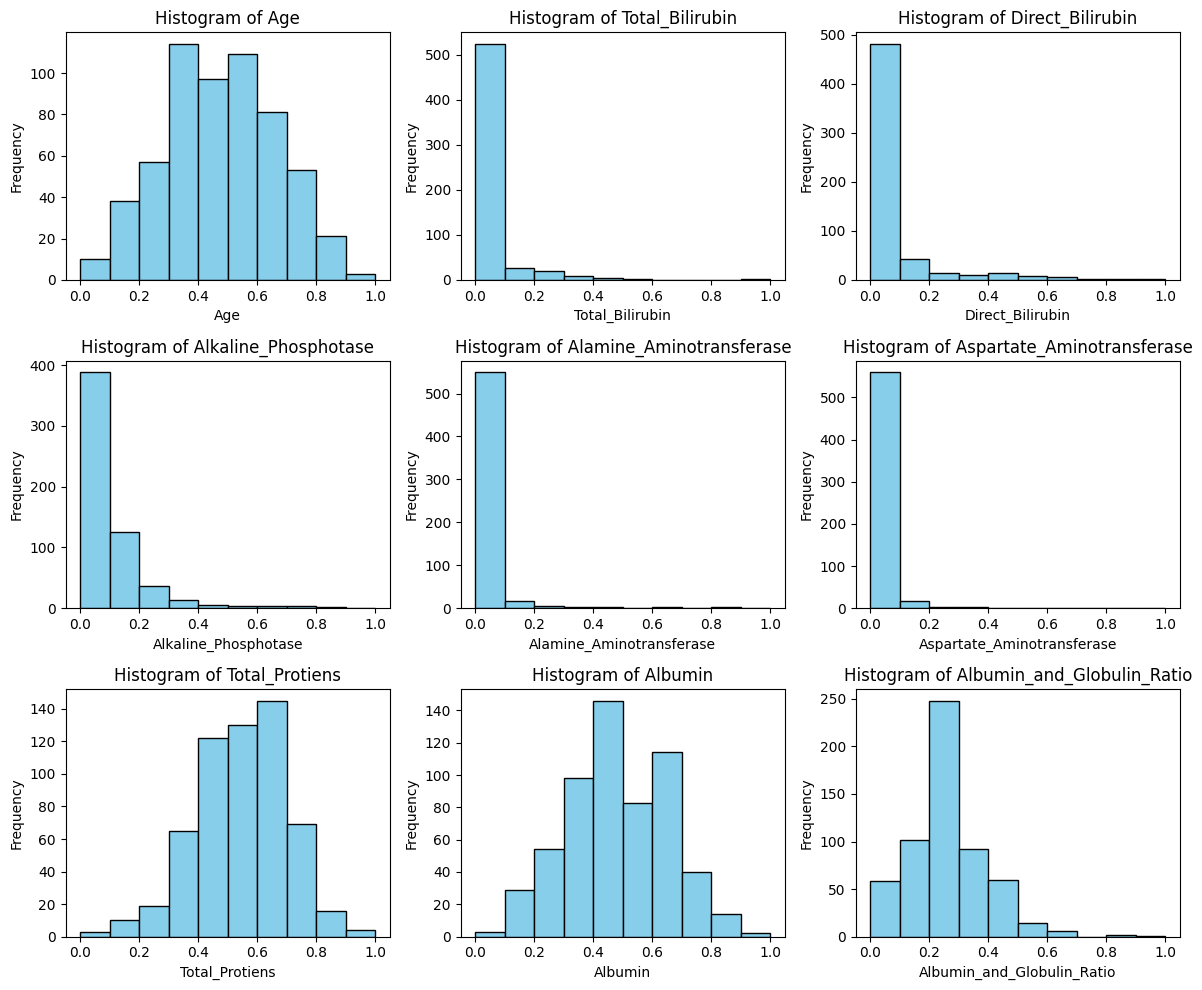

In [17]:
# Pilih kolom untuk EDA
columns_for_eda = ['Age', 'Total_Bilirubin', 'Direct_Bilirubin', 'Alkaline_Phosphotase', 
                   'Alamine_Aminotransferase', 'Aspartate_Aminotransferase', 
                   'Total_Protiens', 'Albumin', 'Albumin_and_Globulin_Ratio']

# Buat histogram untuk setiap kolom
plt.figure(figsize=(12, 10))
for i, column in enumerate(columns_for_eda, 1):
    plt.subplot(3, 3, i)
    plt.hist(df[column], bins=10, color='skyblue', edgecolor='black')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {column}')

plt.tight_layout()
plt.show()

**outliers will not be handled, cause the data only contain a small of record**

## data correlation

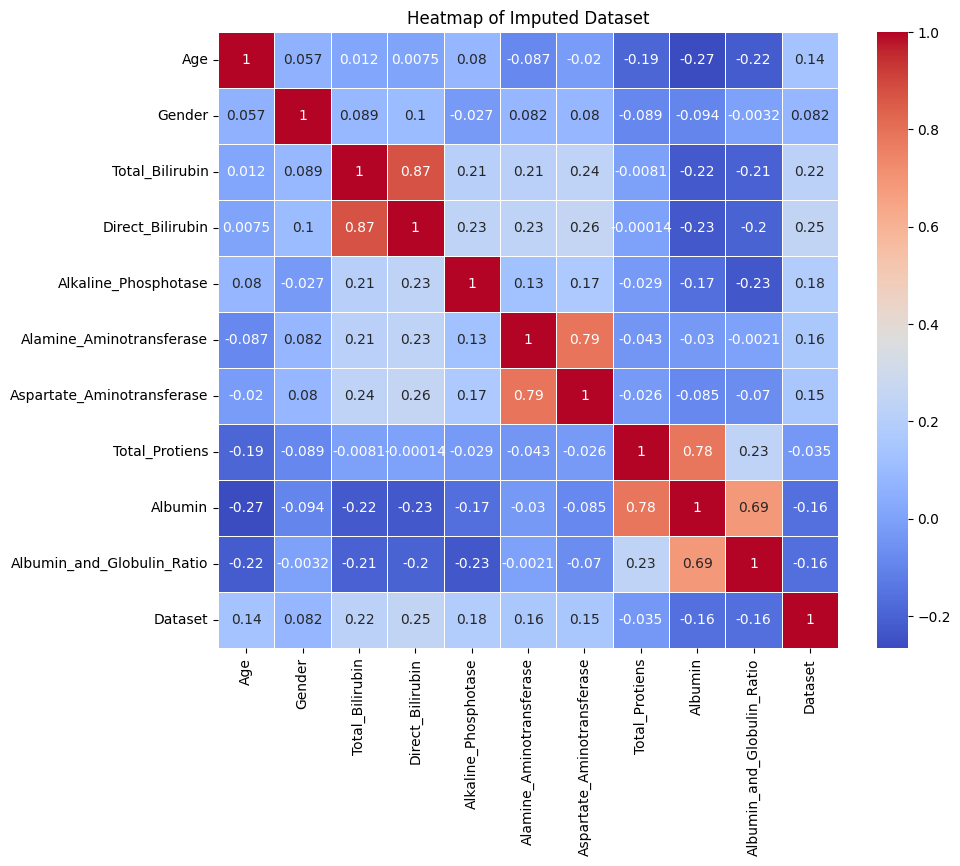

In [18]:
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap of Imputed Dataset')
plt.show()

## modelling

In [19]:
X = df.drop('Dataset', axis=1)
y = df['Dataset']

smote_nc = SMOTENC(categorical_features=[1], random_state=42)

X_resampled, y_resampled = smote_nc.fit_resample(X, y)

df_resampled = pd.concat([X_resampled, y_resampled], axis=1)

print("Class Distribution after Oversampling:")
print(Counter(df_resampled['Dataset']))

Class Distribution after Oversampling:
Counter({1: 416, 0: 416})


## bagging

In [20]:
# Initialize Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100)

# Initialize Bagging classifier with Random Forest
bagging_classifier = BaggingClassifier(base_estimator=rf_classifier, n_estimators=10, random_state=42)

# Initialize k-fold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# Perform k-fold cross-validation and get accuracy scores
scores = cross_val_score(bagging_classifier, X_resampled, y_resampled, cv=kfold)

# Print the accuracy scores
print("Accuracy Scores:", scores)
print("Mean Accuracy:", scores.mean())

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/en

Accuracy Scores: [0.78571429 0.85714286 0.75903614 0.77108434 0.75903614 0.8313253
 0.80722892 0.78313253 0.84337349 0.84337349]
Mean Accuracy: 0.8040447504302926


## boosting

In [21]:
# Initialize CatBoost classifier with verbose=0
catboost_classifier = CatBoostClassifier(iterations=100, learning_rate=0.1, verbose=0, random_state=42)

# Initialize k-fold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# Perform k-fold cross-validation and get accuracy scores
scores = cross_val_score(catboost_classifier, X_resampled, y_resampled, cv=kfold)

# Print the accuracy scores
print("Accuracy Scores:", scores)
print("Mean Accuracy:", scores.mean())

Accuracy Scores: [0.75       0.78571429 0.75903614 0.73493976 0.74698795 0.80722892
 0.74698795 0.77108434 0.81927711 0.74698795]
Mean Accuracy: 0.7668244406196214


## stacking

In [22]:
# Initialize base models with verbose=0
knn_model = KNeighborsClassifier()
nb_model = GaussianNB()
lgbm_model = LGBMClassifier(verbosity=-1)
svm_model = SVC(verbose=0)
xgb_model = XGBClassifier()
rf_model = RandomForestClassifier()

# Initialize meta model
lr_model = LogisticRegression()

# Define stacking classifier
stacking_classifier = StackingClassifier(
    estimators=[
        ('knn', knn_model),
        ('nb', nb_model),
        ('lgbm', lgbm_model),
        ('svm', svm_model),
        ('xgb', xgb_model),
        ('rf', rf_model)
    ],
    final_estimator=lr_model
)

# Initialize k-fold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# Perform k-fold cross-validation and get accuracy scores
scores = cross_val_score(stacking_classifier, X_resampled, y_resampled, cv=kfold)

# Print the accuracy scores
print("Accuracy Scores:", scores)
print("Mean Accuracy:", scores.mean())

Accuracy Scores: [0.8452381  0.86904762 0.75903614 0.75903614 0.79518072 0.81927711
 0.81927711 0.8313253  0.84337349 0.84337349]
Mean Accuracy: 0.8184165232358003
